<a href="https://colab.research.google.com/github/07HUB17/Python/blob/main/%E3%83%AC%E3%83%BC%E3%83%80%E3%81%AE%E3%83%91%E3%83%AB%E3%82%B9%E5%9C%A7%E7%B8%AE_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MathWorksのパルス圧縮のドキュメントをpythonコードに変換したテキスト**

この例では、送信パルスの変調と、受信信号との相関を行う、"パルス圧縮" の効果を説明します。パルス圧縮は、レーダー システムやソナー システムにおいて、エコーの持続時間を短くすることで S/N 比 (SNR) と範囲分解能を改善するために使用されます。

**時間領域の相互相関**

矩形チャープ
最初に、矩形パルスでのパルス圧縮を可視化します。周波数 f0 を 10 Hz、サンプル レート fs を 1 kHz として、長さ 1 秒間のパルスを作成します。

In [ ]:
import numpy as np
import math
import random
from matplotlib import pyplot as plt
PI=math.pi

In [ ]:
fs = 1000;
tmax = 15;
tt = np.arange(0,tmax-1/fs,1/fs)
f0 = 10;
T = 1;
t = np.arange(0,T-1/fs,1/fs)
pls = np.cos(2*PI*f0*t);

最初のパルスに基づき、ノイズなしで、5 秒から開始する受信信号を作成します。この信号は、徐々に離れていくターゲットを表し、反射される信号は 2 秒ごとに分割されます。反射率項 ref は、受信パルスが、送信パワーのどれくらいの割合をもっているかを決定します。減衰係数 att は、信号の強さが時間の経過につれてどのくらい減少するかを示します。

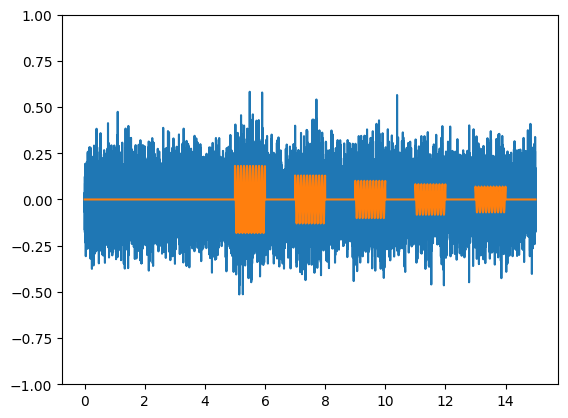

In [ ]:
t0 = 5
dt = 2*T
pls_num=(tmax-t0)//dt
lgs = np.arange(t0,tmax,dt)
att = 1.1
ref = 0.2
t_att=(tt*att)
#rpls_zero = [0]*len(tt)
#signal
rpls = [0]*len(tt)
for i in range(pls_num):
  rpls[(t0+dt*i)*fs:(t0+T+dt*i)*fs-1]=pls*ref/(att*((t0+dt*i)/t0))

#noise
SNR=15
#r=np.array([random.gauss(0 , np.std(pls)*10^(-1*SNR/10)) for i in range(len(tt))])
r=np.random.normal(0,np.std(pls)*10**(-1*SNR/20),len(tt))
rplsnoise=r+rpls
plt.plot(tt,rplsnoise,tt,rpls)
plt.ylim(-1,1)
plt.show()


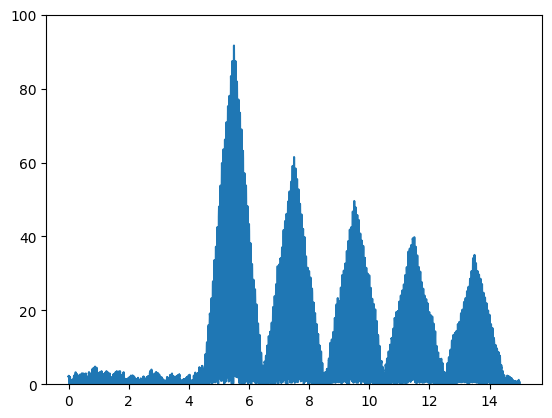

In [ ]:
m=np.correlate(rplsnoise,pls,'same')
plt.plot(tt,abs(m))
plt.ylim(0,100)
plt.show()

これが複数のターゲットからのエコーであれば、エコーは十分に離れて広がるのでターゲットの位置を把握することが可能です。しかし、ターゲットが近接している場合、それらの応答は混合されます。

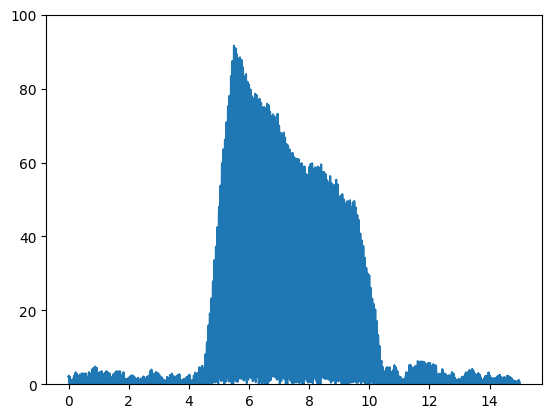

In [ ]:
dt = 1*T
dts=int(dt*fs)
rpls = [0]*len(tt)
for i in range(pls_num):
  #rpls[(t0+dt*i)*fs:(t0+T+dt*i)*fs-1]=pls*ref/(att*((t0+dt*i)/t0))
  rpls[(t0)*fs+dts*i:(t0+T)*fs+dts*i-1]=pls*ref/(att*((t0+dt*i)/t0))
rplsnoise=r+rpls
m=np.correlate(rplsnoise,pls,'same')
plt.plot(tt,abs(m))
plt.ylim(0,100)
plt.show()

線形周波数変調 (FM) チャープ


複素数値線形 FM 信号は、整合フィルター応答が大きく、かつ狭くなるので、実際のレーダー システムで範囲分解能を向上させるためによく使われます。チャープと整合フィルターに虚数部があるので、すべてのプロットは波形の実数部を使用して作られなければなりません。

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


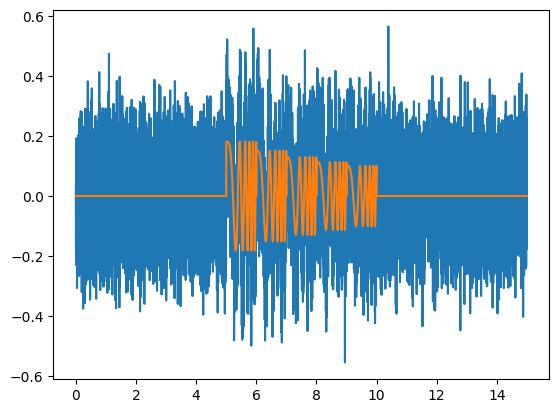

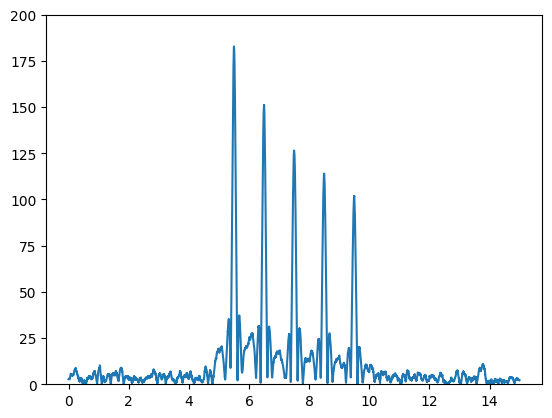

In [ ]:
#波形作成
pls=np.exp(1j*PI*f0/T*t**2)
dt = 1*T
dts=int(dt*fs)
rpls = [0]*len(tt)
for i in range(pls_num):
  rpls[(t0)*fs+dts*i:(t0+T)*fs+dts*i-1]=rpls[(t0)*fs+dts*i:(t0+T)*fs+dts*i-1]+pls*ref/(att*((t0+dt*i)/t0))
rplsnoise=r+rpls
m=np.correlate(rplsnoise,pls,'same')

plt.plot(tt,rplsnoise,tt,rpls)
plt.show()

plt.plot(tt,abs(m))
plt.ylim(0,200)
plt.show()

相互相関は範囲分解能を向上させますが、このアルゴリズムはアナログ ハードウェア実装の場合のほうが効果的です。多くのレーダー システムは、"整合フィルター処理" と呼ばれる、デジタル領域での同様の処理を採用するようになっています。この処理では、受信信号に、送信パルスの時間反転バージョンで畳み込みが行われます。整合フィルター処理は周波数領域でよく行われます。これは、時間領域での畳み込みは、周波数領域での乗算に相当し、処理が高速になるためです。初回パルスは時間反転されているので、フィルター処理された出力にはパルス幅 T (1 秒) の遅延があります。

これを示すため、元の線形 FM パルスを時間反転してゼロでパディングし、パルスと送信波形が同じ長さになるようにします。時間反転したパルスとノイズのある信号の複素共役のフーリエ変換を計算してプロットします。周波数領域で 2 つのパルスを乗算し、その積をプロットします。

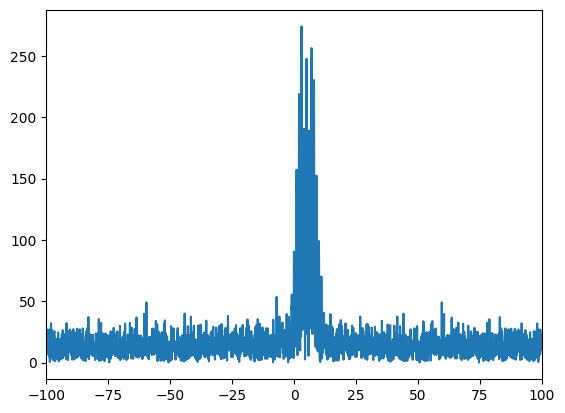

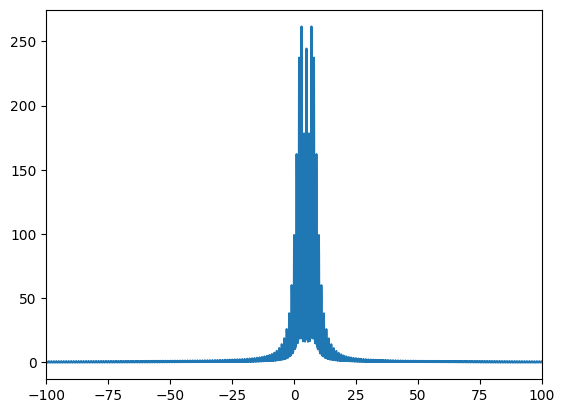

In [ ]:
#周波数領域の畳み込み
#周波数領域への変換
faxis=np.linspace(-fs/2,fs/2,len(tt))
PLS=(np.fft.fft(np.conjugate(rpls)))

R=(np.fft.fft(rplsnoise))
plt.plot(faxis,abs(np.fft.fftshift(R)))
plt.xlim(-100,100)
plt.show()
plt.plot(faxis,abs(np.fft.fftshift(PLS)))
plt.xlim(-100,100)
plt.show()


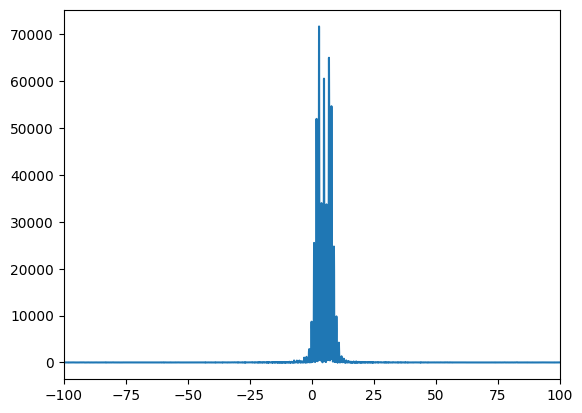

In [ ]:
#周波数領域での掛け算とIFFT
#pulsecomp_signal_dd=np.conjugate(ref_signal_dd)*chirp_pulse
fft_conv=(PLS)*R
plt.plot(faxis,abs(np.fft.fftshift(fft_conv)))
plt.xlim(-100,100)
plt.show()
pls_prod=np.fft.ifft((fft_conv))

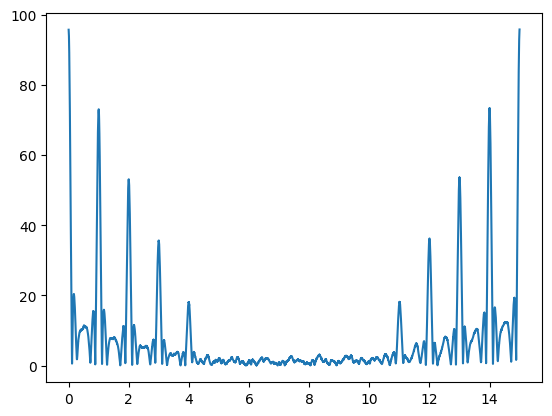

In [ ]:
#グラフの表示
plt.plot(tt,np.abs((pls_prod)))
plt.show()

ウィンドウを使用したサイドローブ削減

整合フィルター処理後のサイドローブを平滑化するため、時間反転の前に送信パルスにウィンドウを適用します。上記のセクションの手順は、周波数領域での整合フィルター処理プロセスをより明確に可視化するために示したものです。関数 fftfilt は、整合フィルター処理を関数にすばやく適用できます。

<ipython-input-203-324cb9987124>:2: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window=signal.hann(len(t_pw))


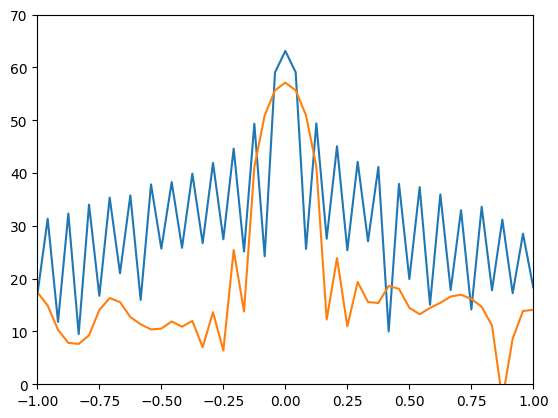

In [ ]:
from scipy import signal
window=signal.hann(len(t_pw))
#時間領域の畳み込み
pulsecomp_signal_win=np.correlate((chirp_pulse_noise*window),chirp_pulse,'same')
plt.plot(t_pw,20*np.log10(abs(pulsecomp_signal)),t_pw,20*np.log10(abs(pulsecomp_signal_win)))
plt.xlim(-1,1)
plt.ylim(0,70)
plt.show()